In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import norm
from torch import optim
from tqdm import tqdm
from torch import nn
import torch
import seaborn as sns
import pyro
import numpy.testing as np_testing
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})

# 0. Seminar plan
    
    1. Fit binomial distribution to the space worms teeth distribution using Wasserstein divergence;
    2. Fit 2D-normal distribution with Wasserstein;
        1. Learn about Kantorovich-Rubinstein duality;
            - Yet another minimax problem!
        2. Learn about weights clipping as a way to ensure 1-Lipschitz;
        3. Leatn about gradient penalty as a way to ensure 1-Lipschitz(extra, no grading).

# 1. Discrete example

In this notebook we're going to take a look at a way of comparing two probability distributions called Kullback-Leibler Divergence. 

## 1.1 Space worms teeth distribution

Suppose that we're space-scientists visiting a distant, new planet and we've discovered a species of biting worms that we'd like to study. We've found that these worms have 10 teeth, but because of all the chomping away, many of them end up missing teeth. After collecting many samples we have come to this empirical probability distribution of the number of teeth in each worm:
 
![Space worms](https://images.squarespace-cdn.com/content/v1/54e50c15e4b058fc6806d068/1494401025139-ODE7CP2043TS1CO9MQSN/ke17ZwdGBToddI8pDm48kLuT3KTpMRZ2imBrzIWD9_5Zw-zPPgdn4jUwVcJE1ZvWEtT5uBSRWt4vQZAgTJucoTqqXjS3CfNDSuuf31e0tVG-_BClLJADi5Tjms1vR9XfE3ardhQXleMJTem2-1ZqRideLm3HbGNLisCtv4-dzhc/biting-worms.jpg?format=1000w)

Picture and idea credits: https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained

In [2]:
# ensure the probability adds up to 1
true_data = torch.tensor([0.1, 0.2, 0.11, 0.11, 0.05, 0.02, 0.03, 0.05, 0.11, 0.15, 0.07])
n = true_data.shape[0]
index = torch.arange(n).float()

In [3]:
np_testing.assert_almost_equal(true_data.sum().item(), 1., err_msg='Your probability do not sum up to 1!')

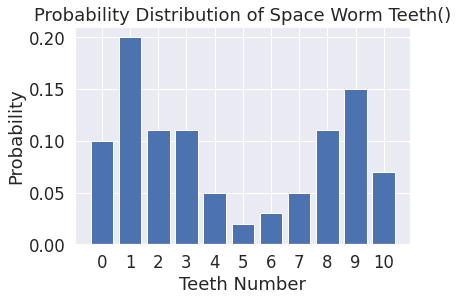

In [4]:
plt.figure()
plt.bar(index, true_data)
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth()')
plt.ylabel('Probability')
plt.xticks(index)
plt.show()

## 1.2 Hypothesis about the data

###### Hypothesis 1: uniform distribution of space worms teeth

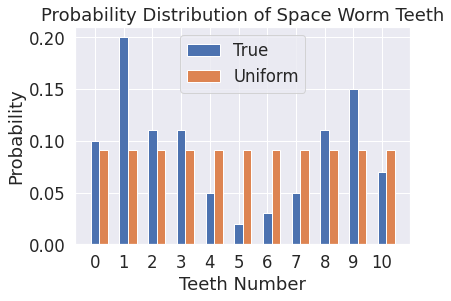

In [5]:
uniform_data = torch.full((n, ), 1.0 / n)

plt.figure()
# we can plot our approximated distribution against the original distribution
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, uniform_data, width=width, label='Uniform')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(index)
plt.legend()
plt.show()

###### Hypothesis 2: binomial distribution with unknown parameter $p$


###### Introducing a new framework: Pyro
Pyro is a flexible, scalable deep probabilistic programming library built on PyTorch. (c) https://github.com/pyro-ppl/pyro

In [6]:
import pyro
from pyro import distributions as distrs

In [7]:
# we estimate the parameter of the binomial distribution
p = true_data.dot(index) / n
print('p for binomial distribution:', p)
binomial_dist = distrs.Binomial(total_count=n, probs=p)
binom_data = binomial_dist.log_prob(index).exp()
binom_data

p for binomial distribution: tensor(0.4100)


tensor([0.0030, 0.0231, 0.0801, 0.1670, 0.2321, 0.2258, 0.1569, 0.0779, 0.0271,
        0.0063, 0.0009])

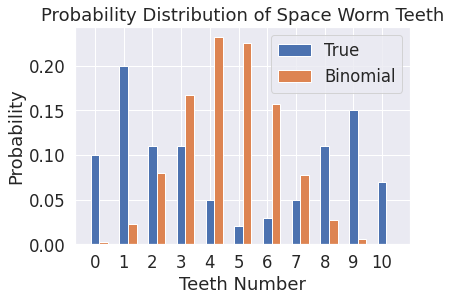

In [8]:
plt.figure()
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, binom_data, width=width, label='Binomial')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(np.arange(n))
plt.legend()
plt.show()

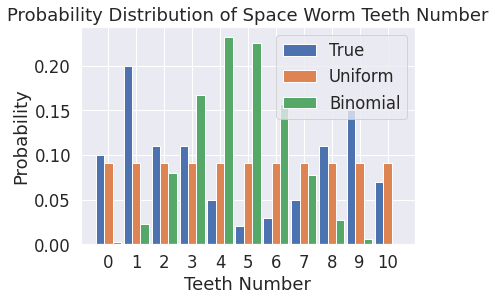

In [9]:
plt.figure()
plt.bar(index - width, true_data, width=width, label='True')
plt.bar(index, uniform_data, width=width, label='Uniform')
plt.bar(index + width, binom_data, width=width, label='Binomial')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth Number')
plt.ylabel('Probability')
plt.xticks(index)
plt.legend()
plt.show()

## And here the math starts

![](https://miro.medium.com/max/600/1*gn5q2deBej2vLLuFzMwLNA.jpeg)

## 1.3 Task: Implementing Wasserstein distance for a discrete distribution

The general formula for Wasserstain distance is:

$$W_p(p, q) = \inf\limits_{\pi \in \Gamma(u, v)} \int\limits_{\mathbb{M} \times \mathbb{M}} d(x, y)^p d \pi(x, y)$$


We are going to discuss the most straightforward case with $p=1$, i.e. pure Earth Moving Distance.

In this case, the formula is simplified:

$$W_1(p, q) = \inf\limits_{\pi \in \Gamma(u, v)}  \int\limits_{\mathbb{R} \times \mathbb{R}} |x - y| \pi(x, y)$$

The physical meaning: how to make a minimal amount of work to transfer earth from one heap to another:
![](https://sbl.inria.fr/fig/Earth_mover_distance_logo.png)

In [10]:
from scipy.stats import wasserstein_distance

#### Note that `scipy.stats.wasserstein_distance` takes as an input distribution and not a probability density function

In [11]:
def wasserstein_distance_for_pdf(p_probs, q_probs):
    """
    Task is to implement wasserstein distance computation for pdfs with scipy.stats.wasserstein_distance
    """
    w = (p_probs.cumsum(dim=0) - q_probs.cumsum(dim=0)).abs().sum() / len(p_probs)
    return w

In [12]:
np_testing.assert_almost_equal(
    wasserstein_distance_for_pdf(torch.full((10, ), 1.0 / 10), torch.full((10, ), 1.0 / 10)).item(),
    0.,
)

np_testing.assert_almost_equal(
    wasserstein_distance_for_pdf(torch.full((10, ), 1.0 / 10), torch.arange(10).float() / torch.arange(10).sum()).item(),
    0.18333333563059567,
)

np_testing.assert_almost_equal(
    wasserstein_distance_for_pdf(torch.arange(9, -1, -1).float() / 45, torch.arange(10).float() / 45).item(),
    0.3666666692122817,
)

## Not differentiable :(

For $W_1$ in 1dim case we have a closed form expression for Wasserstein distance:


$$W_1(p, q) =  \int\limits_{-\infty}^{+\infty} |P(x) - Q(x)| dx = \int\limits_{-\infty}^{+\infty}\left|\int\limits_{-\infty}^{x} P(y) - Q(y)dy \right| dx$$


Very difficult to prove, just belive me, please: 

https://www.stat.cmu.edu/~larry/=sml/Opt.pdf

In [13]:
def compute_wasserstein_distance(p_probs, q_probs):
    """
    Task is to implement wasserstein distance using the formula from above
    """
    w = (p_probs.cumsum(dim=0) - q_probs.cumsum(dim=0)).abs().sum() / len(p_probs)
    return w

In [14]:
np_testing.assert_almost_equal(
    compute_wasserstein_distance(torch.full((10, ), 1.0 / 10), torch.full((10, ), 1.0 / 10)).item(),
    0.,
)

np_testing.assert_almost_equal(
    compute_wasserstein_distance(torch.full((10, ), 1.0 / 10), torch.arange(10).float() / torch.arange(10).sum()).item(),
    0.18333333563059567,
)

np_testing.assert_almost_equal(
    compute_wasserstein_distance(torch.arange(9, -1, -1).float() / 45, torch.arange(10).float() / 45).item(),
    0.3666666692122817,
)

#### Notice that now we have `grad_fn=<ExpBackward>`

In [15]:
p = torch.tensor(0.5, requires_grad=True)

binomial_dist = distrs.Binomial(total_count=n, probs=p)
binom_data = binomial_dist.log_prob(index).exp()
binom_data

tensor([0.0005, 0.0054, 0.0269, 0.0806, 0.1611, 0.2256, 0.2256, 0.1611, 0.0806,
        0.0269, 0.0054], grad_fn=<ExpBackward>)

In [16]:
w = compute_wasserstein_distance(true_data, binom_data)

In [17]:
w

tensor(0.1943, grad_fn=<DivBackward0>)

#### Because W have  `grad_fn=<MeanBackward0>` we can apply `.backward()` method to compute the gradients w.r.t. `p`

In [18]:
w.backward()

In [19]:
p, p.grad

(tensor(0.5000, requires_grad=True), tensor(0.2480))

### 1.6 Task: Implementing optimization procedure

In [20]:
from collections import defaultdict
EPS = 1e-3

def optimize_binomial_distribution(func, p, true_data, lr: float=1e-3, epochs: int=1000):
    """
    func: distance function that takes two arguments
    p: initial guess on parameter p of binomial distribution
    true_data: true_data
    lr: learning rate
    epochs: number of training iterations
    """
    p = p.clone().detach().requires_grad_(True)
    history = defaultdict(list)
    opt = optim.Adam([p], lr=lr)
    
    n = len(true_data)
    index = torch.arange(n).float()
    
    for i in range(epochs):
        p.data.clamp_(EPS, 1 - EPS)
        # Here your task is to 
        # 1. create binomial distribution with Pyro
        # 2. calculate p.d.f. of the binomial distribution
        # 3. apply func to true_data and p.d.f. from previous step
        # 4. perform usual backprop
        # Do not forget to zero grad after weights update!
        #

        binomial_dist = distrs.Binomial(total_count=n, probs=p)
        binom_data = binomial_dist.log_prob(index).exp()
        d = func(true_data, binom_data)
        d.backward()
        opt.step()
        opt.zero_grad()

        history['epoch'].append(i)
        history['dist'].append(d.item())
        history['p'].append(p.item())

    return p, history

### 1.6.1 Task: Fitting with Wasserstein distance

In [21]:
optimal_p, hist = optimize_binomial_distribution(compute_wasserstein_distance, p, true_data)
print(optimal_p)

tensor(0.4665, requires_grad=True)


In [22]:
np_testing.assert_almost_equal(optimal_p.item(), 0.4665, decimal=3)

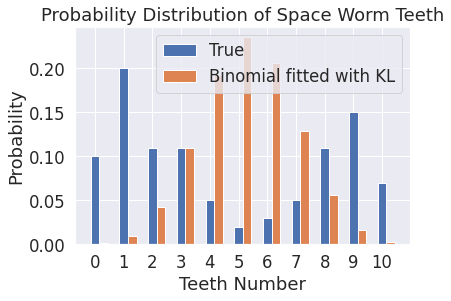

In [23]:
binom_data = distrs.Binomial(total_count=n, probs=optimal_p).log_prob(index).exp().detach()
plt.figure()
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, binom_data, width=width, label='Binomial fitted with KL')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(np.arange(n))
plt.legend()
plt.show()

## 1.7 Wasserstein distance profile

In [24]:
ps = torch.linspace(0. + EPS, 1. - EPS, 100)

In [25]:
ws = [
    compute_wasserstein_distance(distrs.Binomial(total_count=n, probs=p).log_prob(index).exp(), true_data) for p in ps
]

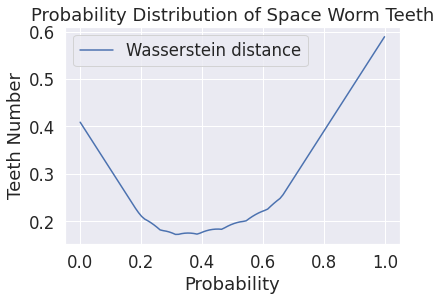

In [26]:
plt.figure()
plt.plot(ps, ws, label='Wasserstein distance')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Teeth Number')
plt.xlabel('Probability')
plt.legend()
plt.show()

# 2. Fitting 2D-normal distribution

Credits: my collegues that https://github.com/HSE-LAMBDA/DeepGenerativeModels

#### Supplementary functions

In [27]:
from pyro.distributions import MultivariateNormal
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)


def get_parameters(mu=0., sigma=1.):
    train_mu = torch.Tensor([mu, mu]).requires_grad_(True)
    train_sigma = torch.Tensor([[sigma, 0.0],
                                [0.0, sigma]]).requires_grad_(True)
    return train_mu, train_sigma

def create_distr(mu, sigma):
    return distrs.MultivariateNormal(mu, sigma)


def sample(d, num):
    return d.sample(torch.Size([num]))

class MixtureDistribution:
    def __init__(self, p1, p2, w=0.5):
        self._p1 = p1
        self._p2 = p2
        self._w = w
        
    def sample(self, n):
        return torch.cat([sample(self._p1, int(n * self._w)), sample(self._p2, n - int(n * self._w))])
    
    def log_prob(self, x):
        return (self._w * self._p1.log_prob(x).exp() + (1. - self._w) * self._p2.log_prob(x).exp()).log()

## 2. Target distribution

Target distribution is a mixture of two 2-dimensionals normal distributions.

### 2.1 Data Generation

In [28]:
P1 = create_distr(
    mu=torch.Tensor([-5, -5]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)
P2 = create_distr(
    mu=torch.Tensor([4, 3]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)

P = MixtureDistribution(P1, P2, 0.5)

samples_x = P.sample(2000)
px = P.log_prob(samples_x).exp()

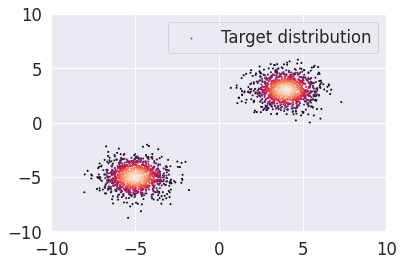

In [29]:
plt.figure()
plot_2d_dots(samples_x, color=px, label='Target distribution')
plt.legend()
plt.show()

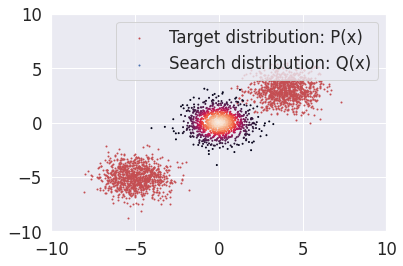

In [30]:
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
samples_q = sample(Q, 1000)
plt.figure()
plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
plot_2d_dots(samples_q, color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')

plt.legend()
plt.show()

$\newcommand\PP{\mathbb{P}}$

### 2.2 Task: optimization of Wasserstein distance in 2D


The equation for the Wasserstein distance is highly intractable. 

\begin{equation*}
    W_p(p_x , q_y)=\inf_{{\gamma \in \Pi (x, y)}}\int D(x,y)^p \gamma (x,y) dx dy,
\end{equation*}



Using the Kantorovich-Rubinstein duality, we can simplify the calculation to:

$\newcommand\EE{\mathbb{E}}$
\begin{equation}
W(p, q) = \sup_{\|f\|_L \leq 1} \EE_{x \sim p}[f(x)] - \EE_{x \sim q}[f(x)]
\end{equation}

where sup is the least upper bound and f is a 1-Lipschitz function, i.e. for some $K$:

$$||f(x) - f(y)|| \leq K ||x - y||$$

So to calculate the Wasserstein distance, we just need to find a 1-Lipschitz function. Like other deep learning problem, we can build a deep network to learn it. 

![WGAN](https://guimperarnau.com/files/blog/Fantastic-GANs-and-where-to-find-them-II/roll_safe_GANs.jpg)

##### Firstly, we are going to generate dataset:

In [31]:
n_p = n_q = 500

In [32]:
samples_q = sample(Q, n_q)
samples_p = P.sample(n_p)

In [33]:
x = torch.cat([samples_p, samples_q]).view(-1, 2)
y = torch.cat([torch.ones(len(samples_p)), 
               torch.zeros(len(samples_q))])

In [34]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.2, random_state=1337
)

## 2.1 How to ensure Lipschitz conditions on network? 
### 2.2 Weight clipping

$$\mathrm{network\_weights} = \mathrm(\mathrm{network\_weights}, c, -c)$$

__Quote from the research paper:__ Weight clipping is a clearly terrible way to enforce a Lipschitz constraint. If the clipping parameter is large, then it can take a long time for any weights to reach their limit, thereby making it harder to train the critic till optimality. If the clipping is small, this can easily lead to vanishing gradients when the number of layers is big, or batch normalization is not used (such as in RNNs) … and we stuck with weight clipping due to its simplicity and already good performance.

https://arxiv.org/pdf/1701.07875.pdf


In [35]:
def clamp_weights(net, clamp=1e-1):
    """
    This function takes a network and clip all weights of the network. 
    I.e. -clamp < weight_i < clamp
    """
    for param in critic.parameters():
        param.data.clamp_(-clamp, clamp)

In [36]:
critic = nn.Sequential(
        nn.Linear(2, 32),
        nn.Tanh(),
        nn.Linear(32, 32),
        nn.Tanh(),
        nn.Linear(32, 1),
)
clamp_weights(critic, clamp=1e-4)
for param in critic.parameters():
    assert (param.data.abs() < 2e-4).all().item() == True

As said erlier to find function f we need to find sup. We can approximate sup with gradient descent by maximizing following expression:

$\newcommand\EE{\mathbb{E}}$
\begin{equation}
 \EE_{x \sim p}[f(x)] - \EE_{x \sim q}[f(x)]
\end{equation}


![](https://matthewmcateer.me/static/f25ae3c02f9f3b3ae46e71f6e9aa0013/39600/gan_training.png)

In [37]:
def create_critic(x, y, input_dim=2, epochs=5):
    """
    This function create and train critic network with weights clipping
    """
    critic = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.Tanh(),
        nn.Linear(32, 32),
        nn.Tanh(),
        nn.Linear(32, 1),
    )
    critic_optim = torch.optim.Adam(critic.parameters(), lr=1e-3)
    for _ in range(epochs):
        critic_optim.zero_grad()
        preds = critic(x)
        # Here your task is to 
        # implement loss function \EE_{x \sim p}[f(x)] - \EE_{x \sim q}[f(x)]
        # it could be one-line solution btw
        #
        
        loss = -((preds.view(-1) * y).sum() - preds.view(-1) * (1 - y)).sum()
        
        loss.backward()
        critic_optim.step()
        clamp_weights(critic, 1e-1)
    return critic

In [38]:
def sample(d, num):
    """
    Sample from distribution num samples with __Pyro__
    """
    res = pyro.sample("dist", d.expand([num]))
    return res

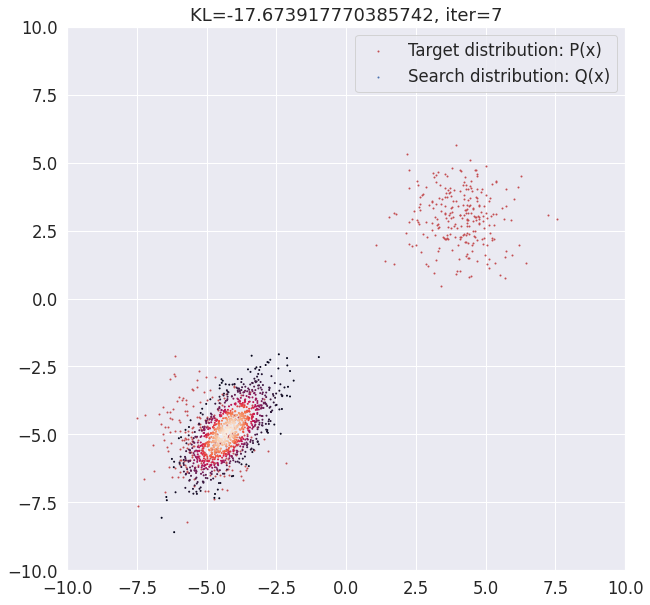

RuntimeError: cholesky_cpu: U(2,2) is zero, singular U.

In [39]:
train_mu, train_sigma = get_parameters(mu=0., sigma=1.)
optim = torch.optim.SGD([train_mu, train_sigma], lr=1e-1)


for i in range(100):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    samples_q = sample(Q, n_q).detach()
    x = torch.cat([samples_p, samples_q])
    y = torch.cat([torch.ones(len(samples_p)), 
                   torch.zeros(len(samples_q))])
    
    critic = create_critic(x, y)
    
    Q = create_distr(train_mu, train_sigma)
    samples_q = sample(Q, n_q)
    
    # Here your task is to 
    # minimize wasserstein distance 
    #
    loss = -critic(samples_q).sum()
    
    loss.backward()
    optim.step()
    if i % 1 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(samples_p.detach(), color='r', label='Target distribution: P(x)')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample.detach(), color= Q.log_prob(q_sample).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

### Sanity check: 

You should observe oscillation of the search distribution. It is like trying to move in one node, then it changes its mind try to go into another mode.

###### _Not working, huh?_

The problem is in weights clipping:

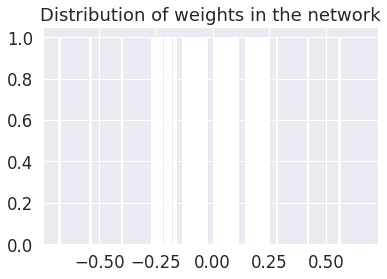

In [40]:
all_weight_of_network = torch.cat([param.view(-1) for param in critic.parameters()]).detach()

plt.figure()
plt.hist(all_weight_of_network)
plt.title("Distribution of weights in the network")
plt.show()

### 2.2 Gradient penalty

_Genious idea!_ If function f is 1-Lipschitz function then gradient $\nabla_x f(x) = 1$ almost everywhere. 

(Theorem about from original paper)

![](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/wgan_theorem.png)

Then our loss function is going to be:

![](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/wgan_loss.png)

We implicitly define $P_{\hat{x}}$ sampling uniformly along straight lines between pairs of points sampled from the data distribution $P_r$ and the generator distribution $P_g$. This is motivated by the fact that the optimal critic contains straight lines with gradient norm 1 connecting coupled points from $P_r$ and $P_g$.



https://arxiv.org/pdf/1704.00028.pdf


![](https://miro.medium.com/max/996/1*2VKp7YH767UPbts1QfHeeA.gif)

In [0]:
def compute_gradient_penalty(critic, x_r, x_q):
    """
    critic: network
    x_r, x_q: data sampled form P and Q distributions
    
    1. ensure that size of x_r and x_q is the same
    2. sample random weights from uniform distribution w = [0, 1]
    3. x_mixed = w x_r + (1 - w) x_r
    4. apply critic to x_mixed
    5. calculate gradient of critic output w.r.t. to x_mixed
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return grad_wrt_mixed_samples

In [0]:
dummpy_critic = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0.1)
        m.bias.data.fill_(0.1)
dummpy_critic.apply(init_weights)
np.random.seed(1337)
res = compute_gradient_penalty(
        dummpy_critic,
        torch.tensor([1., 2., 3., 4.]).view(-1, 2),
        torch.tensor([1., 2., 3., 4.]).view(-1, 2)
    ) - torch.tensor([[0.0856, 0.0856], 
                      [0.0559, 0.0559]])
np_testing.assert_almost_equal(
    res.sum(),
    0.,
    decimal=1e-3
)
np.random.seed()

In [0]:
def create_critic_with_penalty(x, y, input_dim=2, epochs=5):
    """
    This function create and train critic network with weights clipping
    """
    critic = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.Tanh(),
        nn.Linear(32, 32),
        nn.Tanh(),
        nn.Linear(32, 1),
    )
    critic_optim = torch.optim.Adam(critic.parameters(), lr=1e-3)
    for _ in range(epochs):
        critic_optim.zero_grad()
        preds = critic(x)
        
        # Here your task is to 
        # implement loss function \EE_{x \sim p}[f(x)] - \EE_{x \sim q}[f(x)]
        # and add gradient penalty
        # YOUR CODE HERE
        raise NotImplementedError()
        loss.backward()
        critic_optim.step()
    return critic

In [0]:
train_mu, train_sigma = get_parameters(mu=0., sigma=1.)
optim = torch.optim.SGD([train_mu, train_sigma], lr=1e-1)


for i in range(100):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    samples_q = sample(Q, n_q).detach()
    x = torch.cat([samples_p, samples_q])
    y = torch.cat([torch.ones(len(samples_p)), 
                   torch.zeros(len(samples_q))])
    
    critic = create_critic_with_penalty(x, y)
    
    Q = create_distr(train_mu, train_sigma)
    samples_q = sample(Q, n_q)
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    loss.backward()
    optim.step()
    if i % 1 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'W={loss.item()}, iter={i}')
        plot_2d_dots(samples_p.detach(), color='r', label='Target distribution: P(x)')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample.detach(), color= Q.log_prob(q_sample).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

### Sanity check: 

You should observe oscillation of the search distribution. At the end search distribution would try to spread and cover both modes.

In [0]:
all_weight_of_network = torch.cat([param.view(-1) for param in critic.parameters()]).detach()

plt.figure()
plt.hist(all_weight_of_network)
plt.title("Distribution of weights in the network")
plt.show()